# Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

# Setting up Kaggle Directory

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
import keras

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, auc, roc_curve
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalMaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

# Setting up Directory to save model data.

In [2]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = 'C:/Users/Aniket/Emotion Detection'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
  model_dir = os.path.join(project_dir, each_model)
  os.makedirs(model_dir, exist_ok=True)
  # Example subdirectories for model-related files
  # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
  # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
  # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: C:/Users/Aniket/Emotion Detection\FER_2013_Emotion_Detection


# Data Cleaning

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Download the data ['train', 'test'] of emotion faces from kaggle and save it in train test folder. Each folder have ['angry', 'sad', 'disgust', ... 'happy'] folders

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = 'C:/Users/Aniket/Emotion Detection/train'

# Walk through all the dir and files in the dataset
for root, dirs, files in os.walk(data_dir):
  for file in files:
    # Construct the path to the current file
    file_path = os.path.join(root, file)

    try:
      # Check the file type of the current file
      file_type = imghdr.what(file_path)

      # if the file extension is not desired remove it
      if file_type not in image_exts:
        os.remove(file_path)

      else:
        # Proceed to process the image if needed, for example, reading it with OpenCV
        img = cv2.imread(file_path)

    except Exception as e:
      # Print out the issue and the path of the problematic file
      print(f'Issue with the file {file_path}. Error: {e}')
      # Optionally, remove files that cause exceptions
      os.remove(file_path)


# Data Analysis

In [3]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
  # Initialize an empty dictionary to hold the count of the files for each subdirectory
  counts = {}

  # Iterate over each item in the given directory
  for item in os.listdir(directory):
    # Construct the full path to the item
    item_path = os.path.join(directory, item)

    # Check if the path is in the directory
    if os.path.isdir(item_path):
      # Count the number of files in the subdirectory and add it to the dictionary.
      counts[item] = len(os.listdir(item_path))

  # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
  # The index of the DataFrame is set to the provided set name.
  df = pd.DataFrame(counts, index=[set_name])
  return df

# Path to the training and testing directories.
train_dir = 'C:/Users/Aniket/Emotion Detection/train'
test_dir = 'C:/Users/Aniket/Emotion Detection/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the training directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

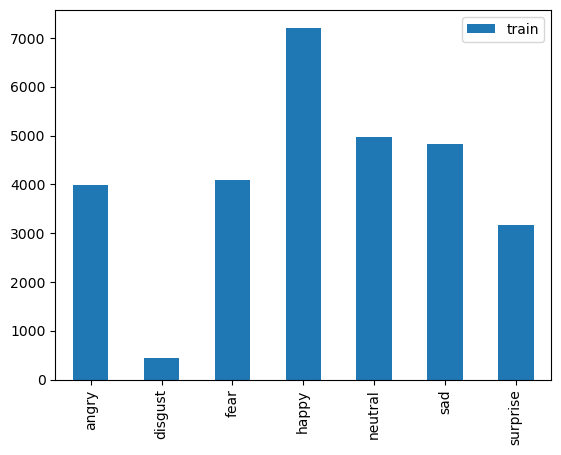

In [16]:
train_count.transpose().plot(kind='bar')

<Axes: >

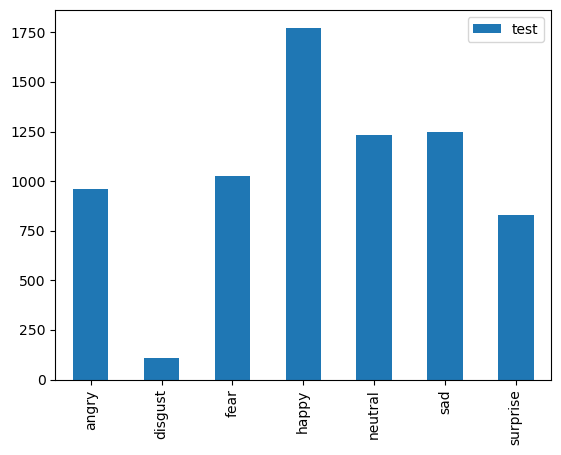

In [18]:
test_count.transpose().plot(kind='bar')

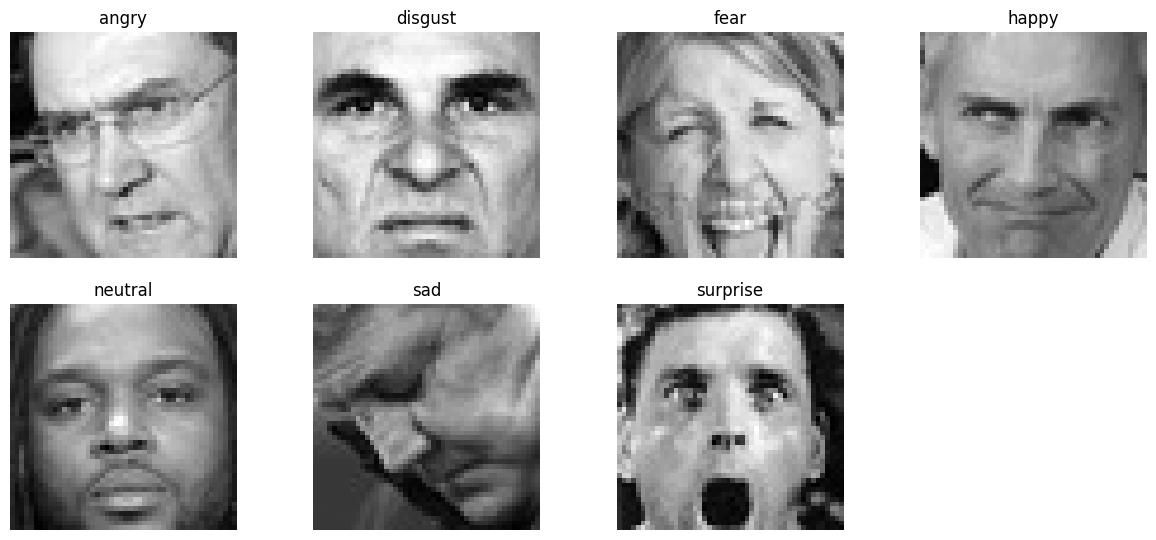

In [7]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
  folder = os.path.join(train_dir, emotion)
  image_path = os.path.join(folder, os.listdir(folder)[42])
  image = plt.imread(image_path)

  plt.subplot(3, 4, i)
  plt.imshow(image, cmap='gray')
  plt.title(emotion)
  plt.axis('off')

# Plotting random images from given directory

In [5]:
def plot_random_images_from_dir(dir_path, cat, num_images=9):
  # If input is a type
  cat = cat.lower()

  # Actual class path
  class_path = os.path.join(dir_path, cat)

  # If num of images is lower in a folder than the num_images
  if len(os.listdir(class_path)) < num_images:
    num_images = len(os.listdir(class_path))

  # Randomly taking out num_images
  indexes = random.sample(range(1,100), num_images)

  # Finding best subplot for the desired num_images
  best_subplot = [(i, num_images // i) for i in range(1, int(num_images**0.5) + 1) if num_images % i == 0][-1]

  # Showing random imgages
  plt.figure(figsize=(15,10))
  for i, index in enumerate(indexes, 1):
    image_path = os.path.join(class_path, os.listdir(class_path)[index])
    image = plt.imread(image_path)

    plt.subplot(best_subplot[0], best_subplot[1], i)
    plt.imshow(image, cmap='gray')
    plt.title(cat)
    plt.axis('off')

### Angry Images

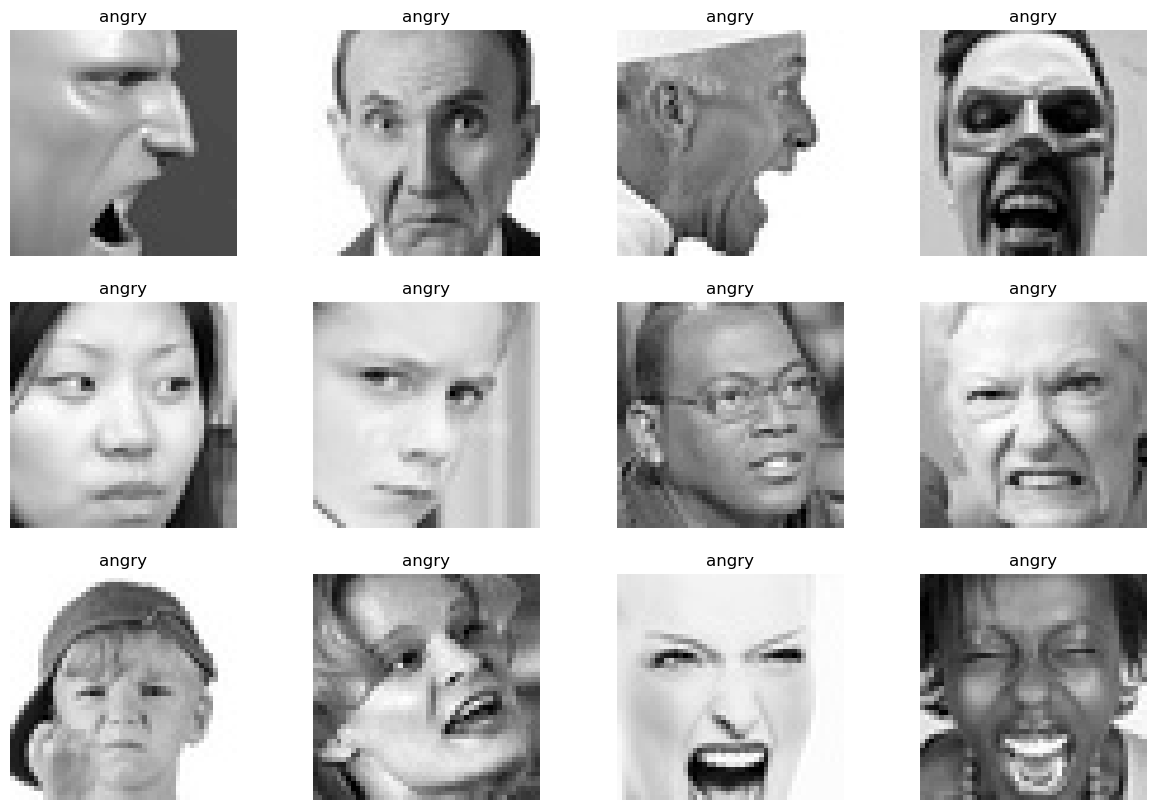

In [25]:
plot_random_images_from_dir(train_dir, 'AnGry', 12)

### Disgust Images

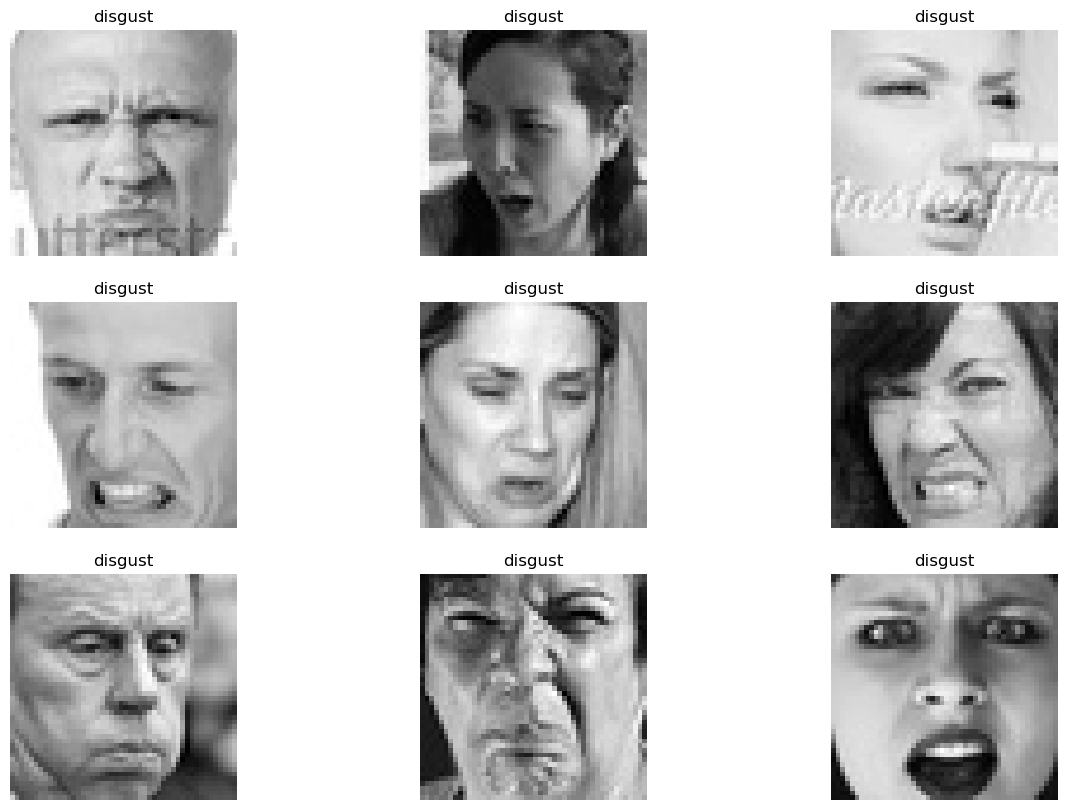

In [27]:
plot_random_images_from_dir(train_dir, 'DISGUST', 9)

### Surprise Images

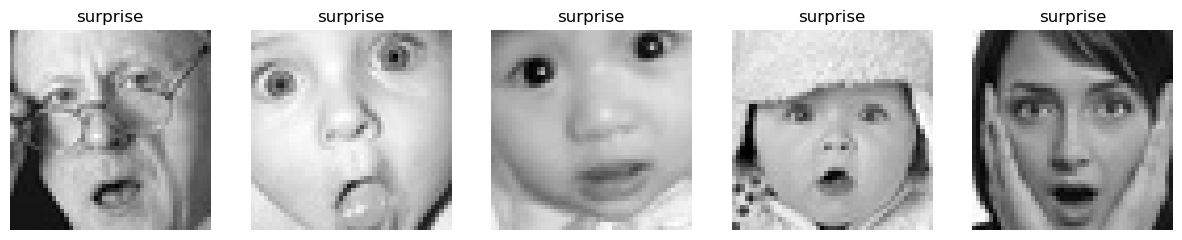

In [29]:
plot_random_images_from_dir(train_dir, 'surprise', 5)

# Checking Shapes and Channels

In [5]:
from pickle import NEWOBJ
image = 'C:/Users/Aniket/Emotion Detection/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format

# If the image is loaded successfully print its pixel value
if img is not None:
  print('Shape: ', img.shape)
else:
  print("The image could not be loaded. Please check the path and file permissions.")

Shape:  (48, 48, 3)


In [6]:
import cv2

image_path = 'C:/Users/Aniket/Emotion Detection/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Model 1: Custom CNN from Scratch

#### Initializing the ImageGenerators

In [4]:
# Define paths of directories
train_data_dir = 'C:/Users/Aniket/Emotion Detection/train'
test_data_dir = 'C:/Users/Aniket/Emotion Detection/test'

In [5]:
# Set some Parameters
img_width, img_height = 48, 48 # Size of the images
batch_size = 64
epochs = 10
num_classes = 7 # Update this based on the no. of classes

In [6]:
# Rescale the pixel values (0-255) to the [0,1] interval
data_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

# Automatically retrieve images and their classes for the train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    # subset = 'testing'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Accessing what class labels assigned for train, test and validation data
train_class_labels = train_generator.class_indices
print('Training class labels: ', train_class_labels)

test_class_labels = test_generator.class_indices
print('Testing class labels: ', test_class_labels)

val_class_labels = validation_generator.class_indices
print('Validation class labels: ', val_class_labels)

Training class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Testing class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [11]:
# Model Building

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), kernel_initializer='glorot_uniform', padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), padding='same',  kernel_regularizer=regularizers.l2(0.01),))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3,3), padding='same',  kernel_regularizer=regularizers.l2(0.01),))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# Flattening the Conv2d for dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layet
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                      

In [13]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

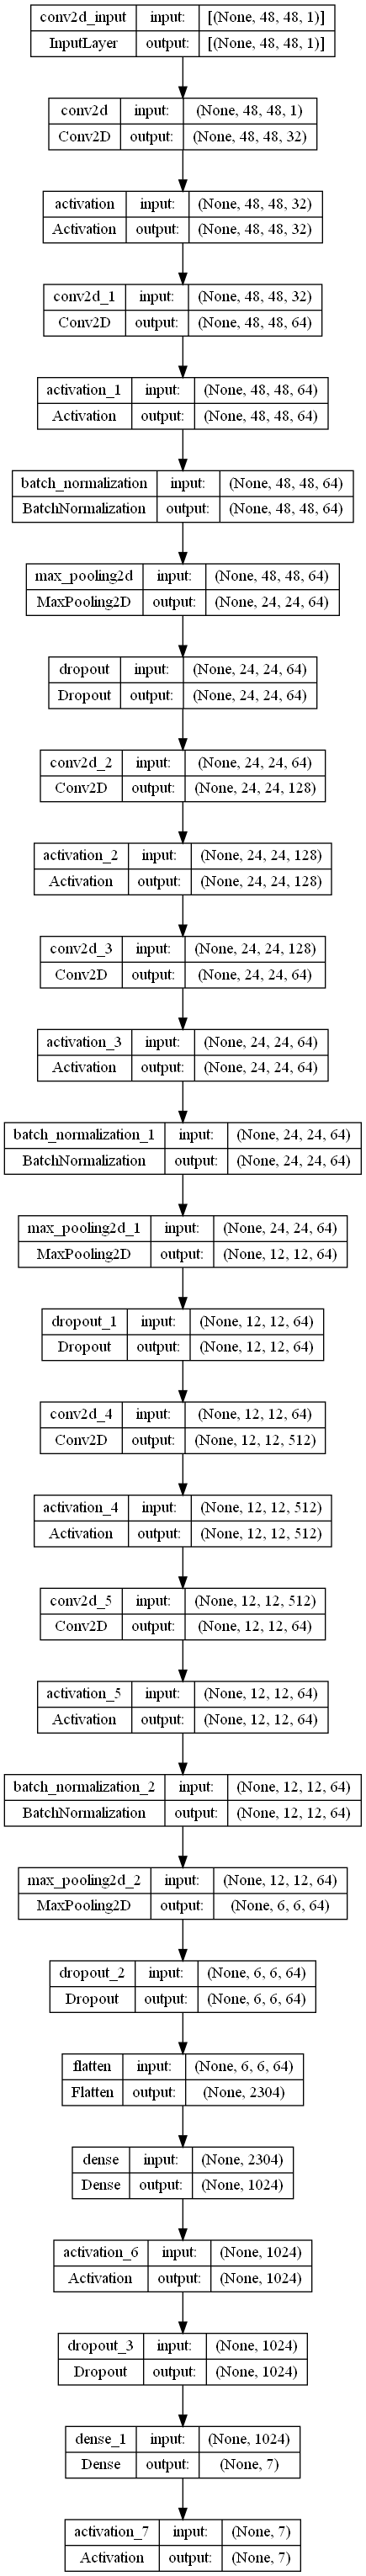

In [14]:
plot_model(model, to_file = 'C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

# Callbacks

In [8]:
# File path for the model checkpoint
cnn_path = 'C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch\\Custom_CNN_model.keras'

In [9]:
# Callbacks to save model checkpoints using this module
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [10]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [11]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [12]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [13]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Calculating Steps for epoch

In [14]:
train_generator.samples

22968

In [15]:
train_steps_per_epochs = train_generator.samples // train_generator.batch_size + 1
validation_steps_epochs = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# Model Training

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epochs,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = validation_steps_epochs,
    callbacks = callbacks
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 5.9486 - accuracy: 0.2473
Epoch 1: val_loss improved from inf to 6.08073, saving model to C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch\Custom_CNN_model.keras
359/359 [==============================] - 243s 625ms/step - loss: 5.9486 - accuracy: 0.2473 - val_loss: 6.0807 - val_accuracy: 0.1313 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 5.1736 - accuracy: 0.3194
Epoch 2: val_loss improved from 6.08073 to 5.00103, saving model to C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch\Custom_CNN_model.keras
359/359 [==============================] - 29s 82ms/step - loss: 5.1736 - accuracy: 0.3194 - val_loss: 5.0010 - val_accuracy: 0.3524 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 4.6794 - accuracy: 0.3612
Epoch 3: val_loss improved from 5.00103 to 4.51454, saving mod

In [21]:
def plot_training_history(history):
    
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20,5))

    # Plot training and validation accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Training loss')
    plt.plot(epochs_range, val_loss, label='Validation loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')

    plt.show()

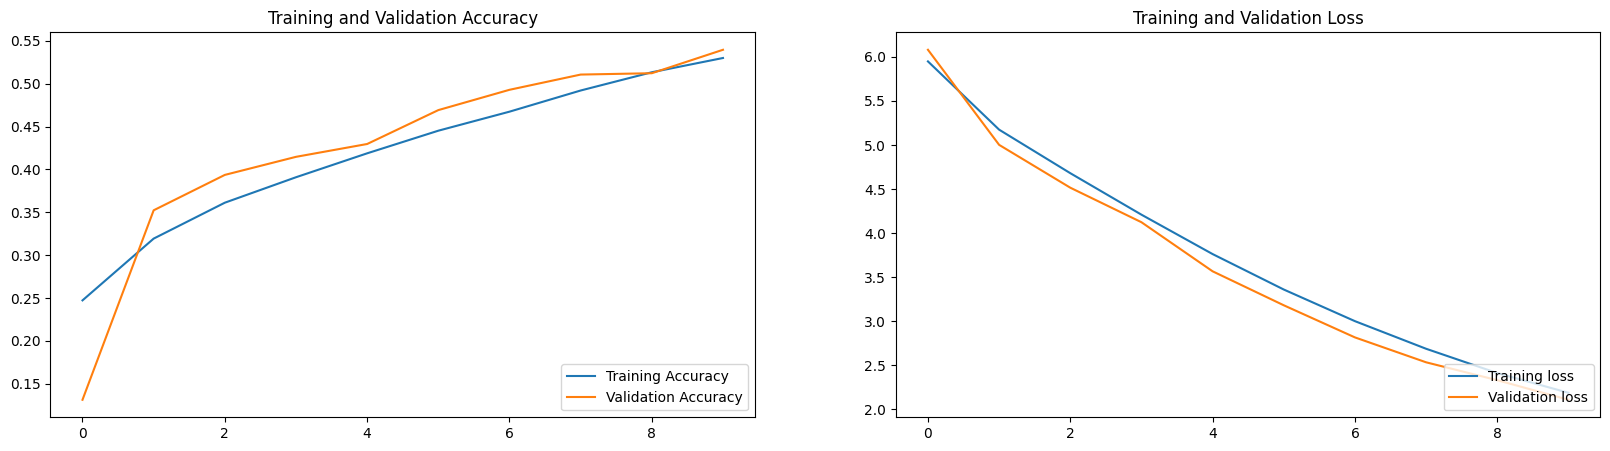

In [26]:
plot_training_history(history)

# Model Evaluation

In [28]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

113/113 [==============================] - 41s 365ms/step - loss: 2.1457 - accuracy: 0.5057
final train accuracy = 55.76 , validation accuracy = 50.57


# Plotting Confusion Matrix

113/113 [==============================] - 2s 21ms/step


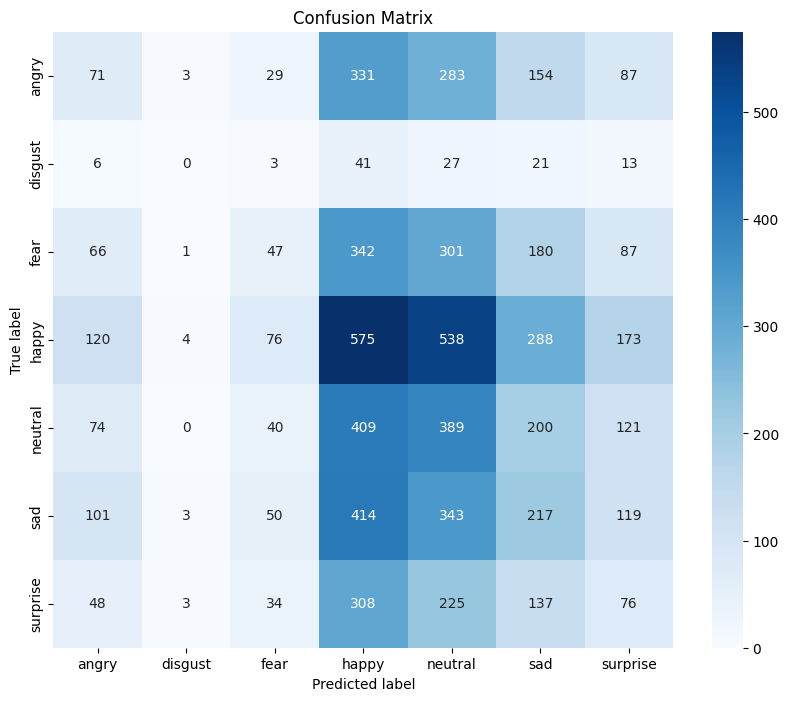

In [30]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)),axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.07      0.10       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.05      0.07      1024
       happy       0.24      0.32      0.27      1774
     neutral       0.18      0.32      0.23      1233
         sad       0.18      0.17      0.18      1247
    surprise       0.11      0.09      0.10       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.19      0.17      7178



# Making Predictions

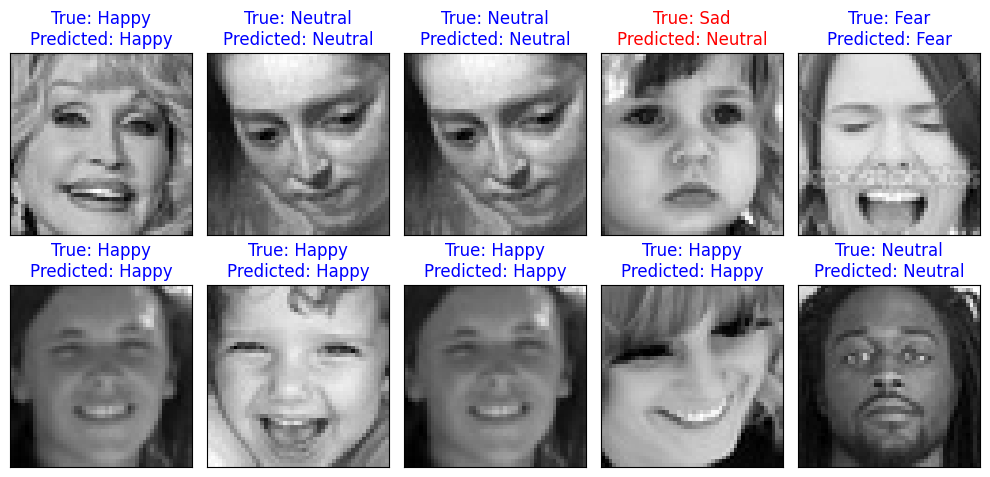

In [27]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) -1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,5),
                        subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]],axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0),axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray') # Assuming the images are grayscale
    
    # Setting the title with the true and predicted labels, colored based on correctness
    color = 'blue' if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else 'red'
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: Image Augmentation

In [44]:
# Define paths of directories
train_data_dir = 'C:/Users/Aniket/Emotion Detection/train'
test_data_dir = 'C:/Users/Aniket/Emotion Detection/test'
# validation_data_dir = 'C:/Users/Aniket/Emotion Detection/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


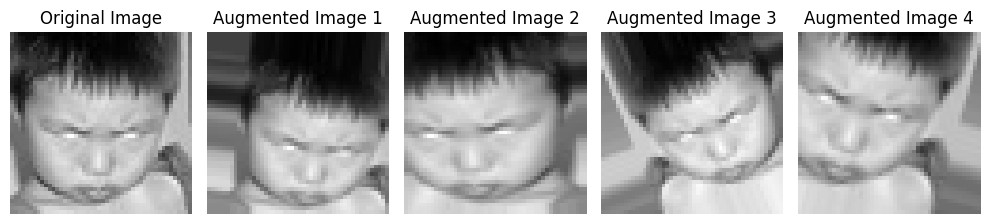

In [63]:
# Path to your specific image
image_path = 'C:/Users/Aniket/Emotion Detection/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [65]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = 'C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 12.4417 - accuracy: 0.2179
Epoch 1: val_loss improved from inf to 13.60289, saving model to C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation\Custom_CNN_augmented_model.keras
359/359 [==============================] - 255s 710ms/step - loss: 12.4417 - accuracy: 0.2179 - val_loss: 13.6029 - val_accuracy: 0.1730 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 10.1777 - accuracy: 0.2365
Epoch 2: val_loss improved from 13.60289 to 9.65334, saving model to C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation\Custom_CNN_augmented_model.keras
359/359 [==============================] - 26s 73ms/step - loss: 10.1777 - accuracy: 0.2365 - val_loss: 9.6533 - val_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 8.0479 - accuracy: 0.2497
Epoch 3: val_loss impr

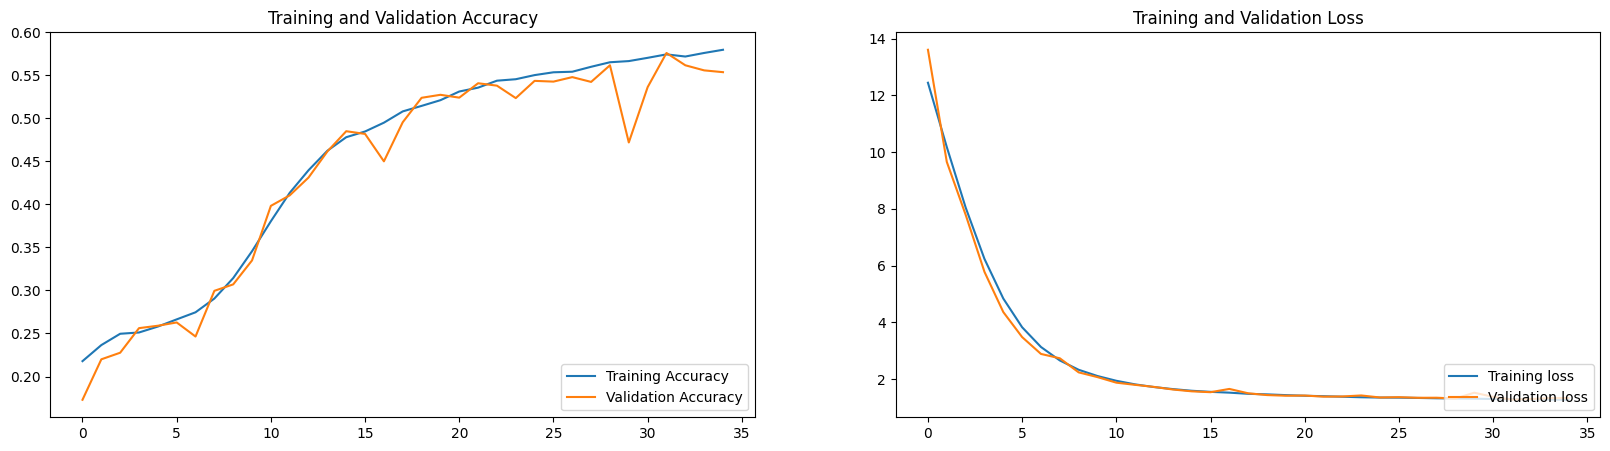

In [66]:
plot_training_history(history)

In [67]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 31s 271ms/step - loss: 1.1820 - accuracy: 0.6092
final train accuracy = 59.66 , validation accuracy = 60.92


113/113 [==============================] - 3s 21ms/step


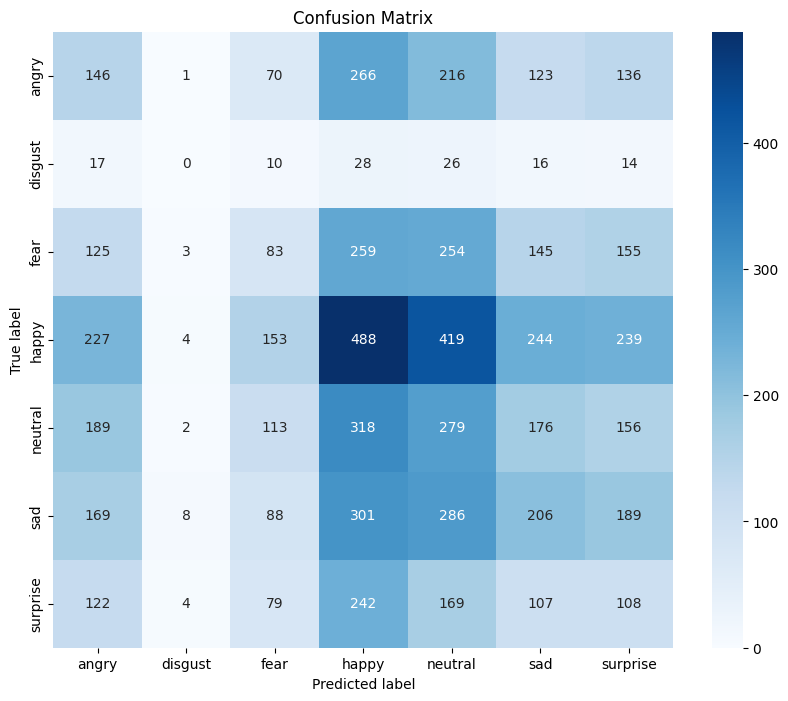

In [68]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Model 3: Transfer Learning VGGNET

In [3]:
# Define paths to the train and validation directories
train_data_dir = 'C:/Users/Aniket/Emotion Detection/train'
test_data_dir = 'C:/Users/Aniket/Emotion Detection/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 32
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [5]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [6]:
# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# Make the specified layers parameters(kernel/filter) non-trainable
for layers in vgg.layers[:-3]:
    layers.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# File path for the model checkpoint
cnn_path = '/C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [43]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=50,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 1.8365 - accuracy: 0.2628
Epoch 1: val_loss improved from inf to 1.63501, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning\VGG16_Transfer_Learning.keras
898/898 [==============================] - 379s 417ms/step - loss: 1.8365 - accuracy: 0.2628 - val_loss: 1.6350 - val_accuracy: 0.3449 - lr: 1.0000e-04
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.6198 - accuracy: 0.3870
Epoch 2: val_loss improved from 1.63501 to 1.47355, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning\VGG16_Transfer_Learning.keras
898/898 [==============================] - 597s 664ms/step - loss: 1.6198 - accuracy: 0.3870 - val_loss: 1.4735 - val_accuracy: 0.4370 - lr: 1.0000e-04
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.5188 - accuracy: 0.4185
Epoch 3: val_loss improved from 1.47355 to 1.37869, saving model to /content/FER_2013_Emotion_De

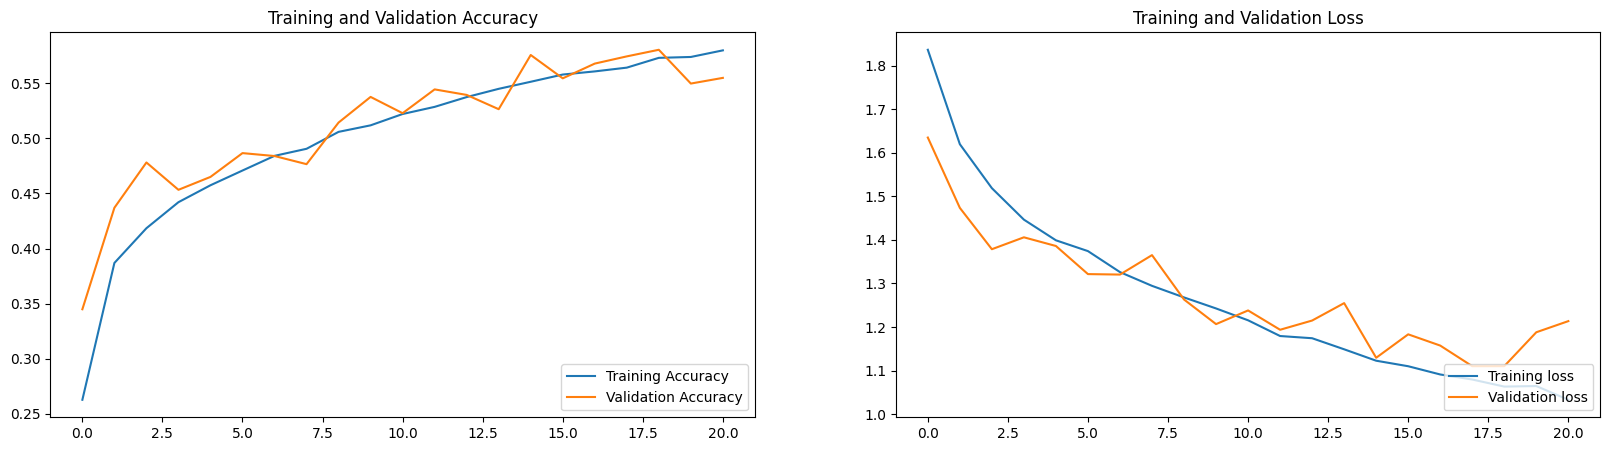

In [44]:
plot_training_history(history)

In [45]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 77s 343ms/step - loss: 1.1102 - accuracy: 0.5744
final train accuracy = 59.49 , validation accuracy = 57.44


225/225 [==============================] - 26s 114ms/step


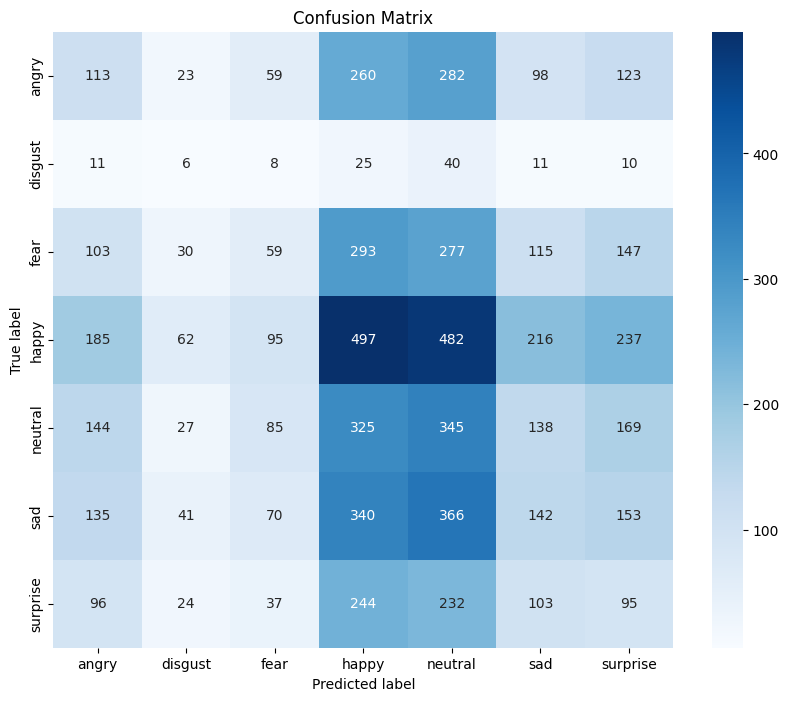

In [46]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [47]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.12      0.13       958
     disgust       0.03      0.05      0.04       111
        fear       0.14      0.06      0.08      1024
       happy       0.25      0.28      0.26      1774
     neutral       0.17      0.28      0.21      1233
         sad       0.17      0.11      0.14      1247
    surprise       0.10      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.15      0.14      7178
weighted avg       0.17      0.18      0.17      7178



# Model 4: Transfer Learning - ResNet50

In [10]:
# Directory paths for training and testing data
train_dir = 'C:/Users/Aniket/Emotion Detection/train'
test_dir = 'C:/Users/Aniket/Emotion Detection/test'

# Batch size for data generators
batch_size = 32

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Introducing Class Weights for imbalanced data

In [11]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [12]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                             include_top=False,
                                             weights='imagenet')

In [13]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [14]:
def create_ResNet50V2_model():

    model = Sequential([
        ResNet50V2,
        Dropout(0.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])

    return model

In [15]:
model = create_ResNet50V2_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# File path for the model checkpoint
cnn_path = 'C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce the learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [18]:
train_history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_steps_epoch,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 2.0424 - accuracy: 0.3068
Epoch 1: val_loss improved from inf to 1.68325, saving model to C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning\ResNet50_Transfer_Learning.keras
898/898 [==============================] - 912s 986ms/step - loss: 2.0424 - accuracy: 0.3068 - val_loss: 1.6833 - val_accuracy: 0.3313
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.6736 - accuracy: 0.3823
Epoch 2: val_loss improved from 1.68325 to 1.36832, saving model to C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning\ResNet50_Transfer_Learning.keras
898/898 [==============================] - 520s 579ms/step - loss: 1.6736 - accuracy: 0.3823 - val_loss: 1.3683 - val_accuracy: 0.4650
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.5632 - accuracy: 0.4133
Epoch 3: val_loss did not improve from 1.36832
898/898 [============

In [19]:
model.save("ResNet50_Transfer_Learning.keras")

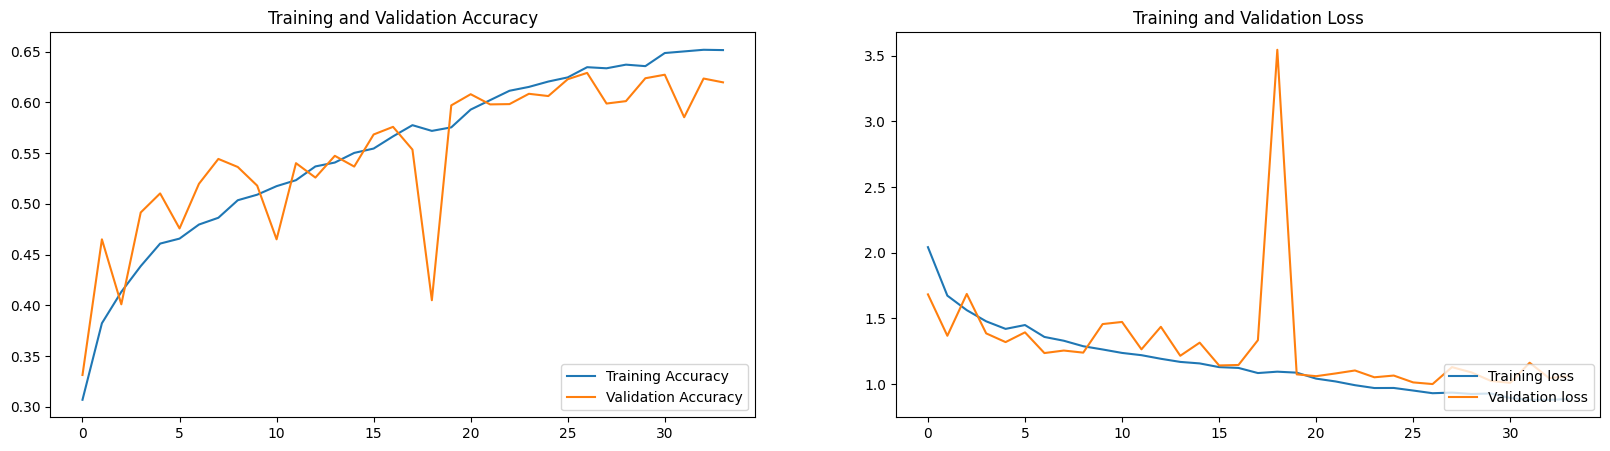

In [22]:
plot_training_history(train_history)

In [23]:
test_loss, test_accu = model.evaluate(test_generator)
print(test_loss, test_accu)

225/225 [==============================] - 117s 520ms/step - loss: 1.0011 - accuracy: 0.6291
1.0010833740234375 0.6291446089744568


In [24]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 38s 170ms/step - loss: 1.0011 - accuracy: 0.6291
final train accuracy = 66.80 , validation accuracy = 62.91


225/225 [==============================] - 17s 75ms/step


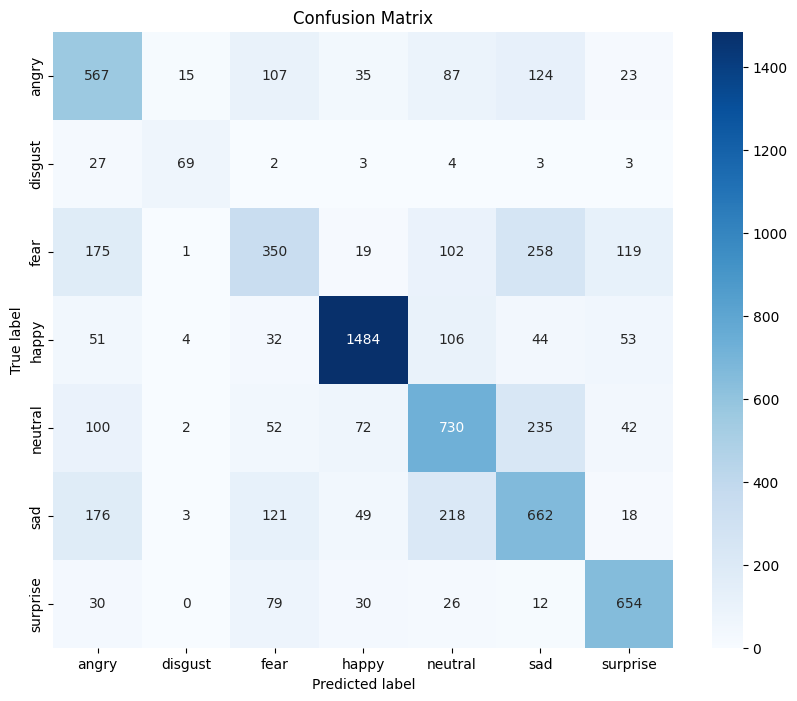

In [25]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [26]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.59      0.54       958
     disgust       0.73      0.62      0.67       111
        fear       0.47      0.34      0.40      1024
       happy       0.88      0.84      0.86      1774
     neutral       0.57      0.59      0.58      1233
         sad       0.49      0.53      0.51      1247
    surprise       0.72      0.79      0.75       831

    accuracy                           0.63      7178
   macro avg       0.62      0.61      0.62      7178
weighted avg       0.63      0.63      0.63      7178



# AUC ROC plot for each class

In [29]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes = list(test_generator.class_indices.keys())

225/225 [==============================] - 14s 64ms/step


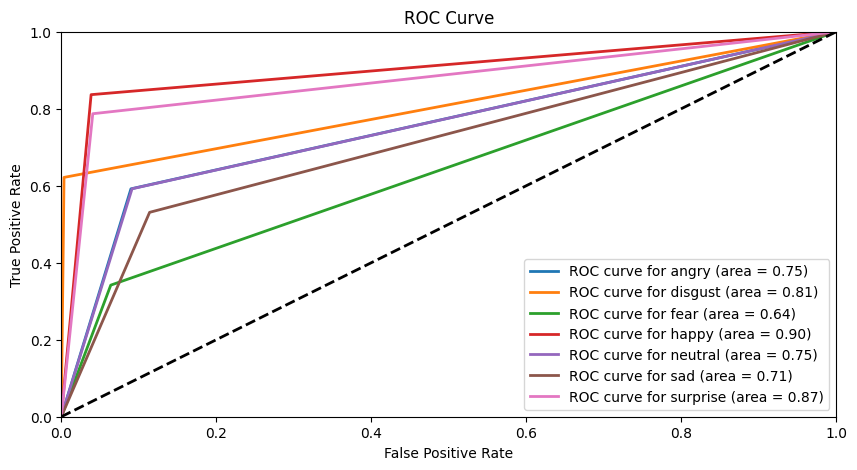

In [30]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Importing ResNet model

In [34]:
!pip install pillow

In [36]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [37]:
# load model
model = load_model("C:/Users/Aniket/Emotion Detection/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras")

In [38]:
# Emotion labels dictionary
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [39]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 20ms/step
